# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Prédictions recueil par prompt engineering

---

# Environnement et données
---

## Environnement

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

## Données

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

In [5]:
labels = ['infox', 'entites_nommees', 'ouverture_esprit', 'faits', 'opinions',
       'propos_raportes', 'sources_citees', 'fausse_nouvelle', 'insinuations',
       'exageration', ]

In [6]:
df_label[labels].describe()

,infox,entites_nommees,ouverture_esprit,faits,opinions,propos_raportes,sources_citees,fausse_nouvelle,insinuations,exageration
count,900.000000,804.000000,803.000000,804.000000,804.000000,803.000000,803.000000,802.000000,802.000000,552.000000
mean,0.414444,0.618159,0.063512,0.717662,0.547264,0.244085,0.400996,0.152120,0.331671,0.317029
std,0.492900,0.486140,0.244033,0.450417,0.498071,0.429811,0.490406,0.359361,0.471107,0.465741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Urls duppliquées

In [7]:
df_label.duplicated(subset='url').sum()

0

### Sites

In [9]:
df_label.value_counts('source')

source
Recueil    613
Test2       99
Test1       96
Verif       96
Name: count, dtype: int64

# Experience
---

## Reduction taille des textes

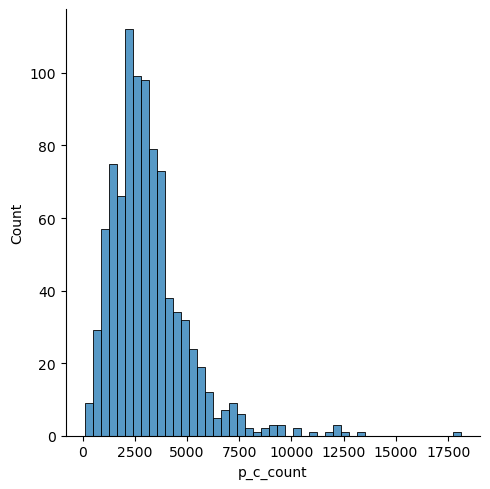

In [20]:
p_count = 13
def partial_texts(text):
    parags = text.split('\n')
    result='\n'.join(parags[:p_count])
    return result

df_label['p_text'] = df_label['text'].apply(partial_texts)

df_label['p_c_count']=df_label['p_text'].apply(len)

sns.displot(df_label['p_c_count'])

In [22]:
df_recueil = df_label[df_label['source']=='Recueil']

In [23]:
df_recueil['p_c_count'].describe()

count      613.000000
mean      3301.497553
std       1819.340458
min        103.000000
25%       2163.000000
50%       3030.000000
75%       4017.000000
max      18123.000000
Name: p_c_count, dtype: float64

## Constitution prompt

In [10]:
import patat.model.gpt

In [12]:
importlib.reload(patat.model.gpt)

<module 'patat.model.gpt' from '/Volumes/Geek/Work/Patat/patat/model/gpt.py'>

In [13]:
gpt = patat.model.gpt.Gpt()

In [18]:
gpt.ask_chat('Que sais tu sur Saint Bonnet les Oules ?')

"Saint Bonnet les Oules est une commune française située dans le département de la Loire, dans la région Auvergne-Rhône-Alpes. Elle fait partie de l'arrondissement de Montbrison et du canton de Saint-Just-Saint-Rambert.\n\nLa commune est située à environ 20 kilomètres au nord de Saint-Étienne. Elle est entourée par les communes de Saint-Just-Saint-Rambert, Saint-Marcellin-en-Forez, Saint-Cyprien et Saint-Georges-Haute-Ville.\n\nSaint Bonnet les Oules est un village rural qui compte environ 1 500 habitants. Son territoire est principalement composé de terres agricoles et de forêts. On y trouve également quelques petites entreprises et commerces.\n\nLe village possède une église datant du XIXe siècle, ainsi qu'un château du XVIIIe siècle qui est aujourd'hui une propriété privée. Il y a également plusieurs sentiers de randonnée qui permettent de découvrir les paysages environnants.\n\nChaque année, Saint Bonnet les Oules organise plusieurs événements festifs, tels que la fête patronale, d

In [14]:
consigne = """
Nous allons te poser des questions dans le cadre d'une expérience où tes réponses seront comparées à des réponses humaines.
Il s'agit de classifer des textes selon une liste de labels prédéfinis.
Pour chacun tes labels, tu répondras 1 pour oui ou 0 pour non.
Les labels sont les suivants :
- infox : contient au moins un fait qui est décrit ou insinué, et qui est faux ou dont la description est exagérée
- lieux, dates et personnes : Mentionne au moins un lieu, une date ou une personne 
- faits : Décrit au moins un fait (un état de chose ou événement, qui peut être vrai ou faux)
- opinions : Formule au moins une opinion 
- subjectif : L’article présente plus des opinions que des faits, 
- propos rapporté : Le contenu de l'article est rapporté par une autre personne ou une autre source, donc l’article est “indirect”, 
- sources citées : Une source d'information (identifiable) est citée, pour un fait au moins
- fausse nouvelle : Un fait décrit dans l’article est faux 
- insinuations : L'article laisse à penser un fait sans le dire explicitement 
- exagération : L’article exagère un fait réel, 
- titre décalé : Le titre est trompeur et ne reflète pas correctement le contenu de l’article
"""

In [51]:
def gpt35_annotate(text):
    prompt = f'{consigne}\nVoici le texte à analyser :\n{text[:10_000]}'
    return gpt.ask_chat(prompt)

In [52]:
text = df_recueil['p_text'].iloc[1]
text

'Les réseaux sociaux coupés volontairement ? Que s’est-il passé ?\nIl semblerait que la panne mondiale des réseaux sociaux liés en partie à Facebook ait été volontairement décidée, en effet, tout ne peut sauter au même moment. 1,5 milliards d’utilisateurs down, du jamais vu. était-ce un test ?\nPendant environ sept heures, les réseaux sociaux Facebook et Instagram mais aussi les messageries WhatsApp ou Messenger étaient totalement inaccessibles. Ce mardi matin, tout est revenu à la normale. Facebook a expliqué par un «\xa0changement de configuration erroné\xa0» la panne d’envergure mondiale.\nPlus de trois milliards d’utilisateurs impactés. Le géant américain du numérique, qui a fait cette annonce dans un message sur son blog lundi soir, n’a pas précisé qui a opéré le changement de configuration et si celui-ci était planifié.\nPlus tôt, plusieurs employés de Facebook, qui ont refusé d’être identifiés et avaient perdu accès à leurs propres outils en raison de la panne, ont déclaré à Reu

In [53]:
response = gpt35_annotate(text)

In [54]:
response

'Voici les réponses pour chaque label :\n\n- infox : 0\n- lieux, dates et personnes : 1\n- faits : 1\n- opinions : 0\n- subjectif : 0\n- propos rapporté : 0\n- sources citées : 1\n- fausse nouvelle : 0\n- insinuations : 0\n- exagération : 0\n- titre décalé : 0'

In [36]:
labels = ['infox', 'entites_nommees', 'ouverture_esprit', 'faits', 'opinions',
       'propos_raportes', 'sources_citees', 'fausse_nouvelle', 'insinuations',
       'exageration', ]
label_translator = {
    'infox':'infox',
    'lieux, dates et personnes':'entites_nommees',
    'faits':'faits',
    'opinions':'opinions',
    'subjectif':'subjectif',
    'propos rapporté':'propos_raportes',
    'sources citées':'sources_citees', 
    'fausse nouvelle':'fausse_nouvelle',
    'insinuations':'insinuations',
    'exagération':'exageration',
    'titre décalé':'titre_decale',
}

In [37]:
def normalize_gpt_text(text):
    text = text.replace('Voici les réponses pour chaque label :\n\n- ','')
    text = text.replace('les informations fournies, voici les réponses aux différentes questions','')  
    text = text.replace('-','')
    return text

In [40]:
def format_gpt_response(text):
    text = normalize_gpt_text(text)
    lines = text.split('\n')
    response = {}
    for line in lines:
        items = line.split(':')
        if len(items)==2:
            if items[1]!='':
                label = label_translator.get(items[0].strip(),items[0].strip())
                response[label]=float(items[1].strip(' '))
    return response

In [41]:
format_gpt_response(response)

{'infox': 0.0,
 'entites_nommees': 1.0,
 'faits': 1.0,
 'opinions': 0.0,
 'subjectif': 0.0,
 'propos_raportes': 0.0,
 'sources_citees': 1.0,
 'fausse_nouvelle': 0.0,
 'insinuations': 0.0,
 'exageration': 0.0,
 'titre_decale': 0.0}

## Prédictions recueil

In [42]:
predictions = []

In [55]:
for index,row in df_recueil.iterrows():
    if index > 201:
        print(index,row['title'])
        predictions.append({
            'url':row['url'],
            'title':row['title'],
            'gpt35-labels': gpt35_annotate(row['p_text']),
        })

202 11 septembre 2001 : La théorie du « complot piraté »
203 Selon un ancien conseiller du Pentagone, les États-Unis auraient attaqué les gazoducs Nord Stream pour isoler l’Allemagne
204 La Pologne s’apprête à s’emparer du territoire de l’Ukraine occidentale, appelé « terres historiques »
205 Exclusivité WikiStrike: un physicien en colère parle d’énergie libre
206 Zelensky parti demander à papa Biden une aide pour son pays et son compte en banque
207 Le chef du renseignement iranien assure que la CIA dicte son carnet de route à Emmanuel Macron
208 La cabale mondialiste promeut un régime à base d’insectes — et de cannibalisme
209 Étude: 22 % des moins de 50 ans diagnostiqués avec une nouvelle maladie post-vaccination
210 “Jour du dépassement”: à partir de ce jeudi 28 juillet, l’humanité vit à crédit
211 Un sosie de Poutine a-t-il été envoyé en Iran ?
212 La Turquie bloque les pourparlers d’adhésion de la Suède et de la Finlande à l’OTAN et présente une liste d’exigences
213 Irak: Découv

302 USA : La Russie a un allié à la Maison Blanche qui aide Poutine à gagner en Ukraine.
303 La fin de la Pax Americana : De la chute d’un empire
304 Pourquoi les États-Unis ont tant besoin de déstabiliser le continent européen ?
305 Black Rock: un problème majeur pour l’humanité
306 Les marxistes cherchent à déstabiliser la société américaine par la sexualisation des jeunes
307 La théorie de la fuite en laboratoire et ce que nous savons de la dissimulation
308 Le Prince Charles a-t-il ignoré les signaux d’alarme indiquant que son ami Jimmy Savile était un agresseur – ou ses assistants ne le lui ont-ils jamais dit ?
309 Un couple âgé de Shanghai révèle sa méthode pour se protéger du Covid
310 Un nouveau livre explore la forte augmentation du nombre de décès chez les jeunes: «Les données sont encore pires que ce que nous pensions»
311 Newsguard : agence de notation des médias et de défense des intérêts américains
312 Tchao Pantine… dans la choucroute
313 Paris : laissé libre après avoir

395 Géopolitique. Une analyse pro-russe de la stratégie militaire en Ukraine
396 Publicité : le Grand Effacement des Blancs
397 Rennes. Reprise des vols commerciaux le 15 juin à l’aéroport
398 Afrique-du-Sud : l’afrikaans, le khoi et le san reconnus comme « langues indigènes »
399 Saint-Brieuc. Rendez-vous incontournable des entrepreneurs bretons, l’Open de l’International 2022 aura lieu le 4 juillet [Vidéo]
400 Le président du conseil départemental 22 Christian Coail se met « en retrait » du PS
401 Incroyable surprise : le repli identitaire islamiste se renforcerait en France !
402 Législatives en Bretagne. Le Parti Breton présente 34 candidats
403 Faux-semblants et vraies raisons du recul de l’âge de départ à la retraite
404 Essais Pfizer sur le vaccin anti-covid : le rapport explosif de Christine Cotton
405 « Quel art ! » : un étudiant en droit invente un système ingénieux pour tricher pendant ses examens
406 L’Australie ne reconnaît plus Jérusalem comme capitale d’Israël
407 Nantes

484 Coup de tonnerre en Espagne : le gouvernement des Baléares avoue que 16 personnes ont été tuées par le vaccin
485 Coup de théâtre : une revue scientifique mondiale confirme que le vaccin provoque des troubles menstruels
486 Gros scandale en France : en pleine crise financière, l’Etat va emprunter 270 milliards d’euros en 2023, du jamais vu
487 France : la plainte contre le professeur Perronne rejetée, en colère, l’Ordre des Médecins menace de faire appel
488 La Russie crache le morceau : « le but des Etats-Unis est d’affaiblir l’Europe militairement et de la désindustrialiser »
489 Gros scandale aux USA : en seulement 9 mois de guerre, les Etats-Unis ont versé 19 milliards à l’Ukraine
490 France : les riches ont pris le pouvoir : 19 ministres de Macron sont millionnaires et possèdent 1,9 millions de patrimoine net
491 Sinon… l’INSEE n’explique pas la hausse de la mortalité en 2022 ! Effets secondaires ?
492 ET SI ON NE NOUS DISAIT PAS TOUT SUR L’UKRAINE ?
493 UNE ENSEIGNANTE TÉMOIG

580 Compostage humain: les “funérailles vertes” gagnent du terrain aux États Unis
581 Présidentielle au Brésil: Bolsonaro talonne Lula, 2e tour tendu en vue
582 La France lance un plan de sobriété énergétique tous azimuts pour affronter l'hiver
583 Est-il encore permis d’avoir des doutes sur la fiabilité du système électoral aux Etats-Unis ?
584 Décision de la CPPAP de retirer son agrément à FranceSoir : la réponse de Xavier Azalbert, directeur de la publication
585 « Coupez ! », vous n’y couperez pas !
586 Hausse des prix des matériaux, qui en paye la note ?
587 Covid-19 : les vaccins ne sont pas sans risques, voici pourquoi
588 Covid-19 : Les effets secondaires camouflés
589 Cet argent magique qui disparait
590 Tous les vitraux de nos églises et cathédrales menacés par l’Union européenne
591 L'efficacité des antidépresseurs remise en cause par des chercheurs
592 « La France insoumise me paraît plus toxique aujourd’hui que le Rassemblement national »
593 Le Costa Rica, exemple en mati

In [50]:
len(df_recueil['p_text'][202][:10_000])

10000

In [62]:
df_pred_text = pd.DataFrame(predictions)
df_pred_text

,url,title,gpt35-labels
0,https://www.alnas.fr/actualite/communaute/lara...,L’Arabie saoudite organise des célébrations d'...,Voici les réponses pour chaque label :\n\n- in...
1,https://lesmoutonsrebelles.com/les-reseaux-soc...,Les réseaux sociaux coupés volontairement ? Qu...,Voici les réponses pour chaque label :\n\n- in...
2,https://lesmoutonsrebelles.com/un-rapport-du-p...,Un rapport du Pentagone affirme que les extrat...,Voici les réponses pour chaque label :\n\n- in...
3,https://lesmoutonsrebelles.com/un-sondage-defa...,Un sondage défavorable pour Emmanuel Macron su...,Voici les réponses pour chaque label :\n\n- in...
4,https://lemediaen442.fr/le-president-ukrainien...,Le président ukrainien Zelensky se cache dans ...,Voici les réponses pour chaque label :\n\n- in...
...,...,...,...
608,https://www.francesoir.fr/politique-france/emm...,Emmanuel Macron va se rendre en Algérie pour “...,Voici les réponses pour chaque label :\n\n- in...
609,https://www.francesoir.fr/politique-france/gue...,Guerre en Ukraine: Emmanuel Macron prévient le...,Voici les réponses pour chaque label :\n\n- in...
610,https://www.francesoir.fr/politique-france/la-...,“La guerre va durer“: Macron prépare les Franç...,Voici les réponses pour chaque label :\n\n- in...
611,https://www.francesoir.fr/politique-monde/turq...,Crise énergétique: la Turquie double ses impor...,Voici les réponses pour chaque label :\n\n- in...


In [64]:
pred_labels = list(df_pred_text['gpt35-labels'].apply(format_gpt_response))

In [71]:
df_pred_labels = pd.concat([df_pred_text,pd.DataFrame(pred_labels)],axis=1)

In [72]:
df_pred_labels

,url,title,gpt35-labels,infox,entites_nommees,faits,opinions,subjectif,propos_raportes,sources_citees,fausse_nouvelle,insinuations,exageration,titre_decale
0,https://www.alnas.fr/actualite/communaute/lara...,L’Arabie saoudite organise des célébrations d'...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,https://lesmoutonsrebelles.com/les-reseaux-soc...,Les réseaux sociaux coupés volontairement ? Qu...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,https://lesmoutonsrebelles.com/un-rapport-du-p...,Un rapport du Pentagone affirme que les extrat...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,https://lesmoutonsrebelles.com/un-sondage-defa...,Un sondage défavorable pour Emmanuel Macron su...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,https://lemediaen442.fr/le-president-ukrainien...,Le président ukrainien Zelensky se cache dans ...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,https://www.francesoir.fr/politique-france/emm...,Emmanuel Macron va se rendre en Algérie pour “...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
609,https://www.francesoir.fr/politique-france/gue...,Guerre en Ukraine: Emmanuel Macron prévient le...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
610,https://www.francesoir.fr/politique-france/la-...,“La guerre va durer“: Macron prépare les Franç...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
611,https://www.francesoir.fr/politique-monde/turq...,Crise énergétique: la Turquie double ses impor...,Voici les réponses pour chaque label :\n\n- in...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [73]:
from sklearn.metrics import accuracy_score

In [101]:
index = df_pred_labels[df_pred_labels['exageration'].notna()].index

In [93]:
df_recueil = df_recueil.reset_index()

In [102]:
accuracy_score(df_recueil.loc[index]['exageration'],df_pred_labels.loc[index]['exageration'])

/opt/homebrew/Caskroom/miniforge/base/envs/pt39/lib/python3.9/site-packages/sklearn/utils/multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


ValueError: Input y_true contains NaN.

# Sauvegarde des résultats
---

In [105]:
df_pred_labels.to_csv('data/tmp/230719-PredLabelsGpt.csv')

# Conclusions
---

# Bricolages
---